## Model Selection Notebook

This notebook will perform model selection on a Kernel SVM to predict binary classification

- Draw Result
- Not Draw Result

In [60]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import sem

numFolds = 5

date = '20170212'

In [61]:
# Load data
data = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/%s_Matches_w_Features_DrawResults.csv'%(date))

In [62]:
for col in data.columns:
    if data[col].dtype == 'object':
        print col

Stage_Cat


In [63]:
del data['Stage_Cat']

In [64]:
print len(data)
print data.shape

2280
(2280, 212)


In [65]:
home_goals = data['home_team_goal']
away_goals = data['away_team_goal']

In [66]:
del data['home_team_goal']
del data['away_team_goal']

In [67]:
print data.shape

(2280, 210)


In [68]:
## First step is to set up training and holdout set
def Assign_Train_Test(df):
    num = random.randint(1,numFolds)
    return num

In [69]:
data['Train_Test'] = data.apply(Assign_Train_Test, axis = 1)

In [70]:
## Chose holdout set as approx 10% of data
holdout = data[data['Train_Test']==1]
train = data[data['Train_Test']!= 1]

# Remove the train_test variable from the dataframes
del holdout['Train_Test']
del train['Train_Test']

print 'Test length ' + str(len(holdout))
print 'Train length ' + str(len(train))

Test length 458
Train length 1822


In [71]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [72]:
def FitPredict(x_train,y_train,x_test,model):
    
    fit_model = model.fit(x_train,y_train)
    preds = fit_model.predict(x_test)
    
    return preds

def ComputeErrorMetric(y_true,y_pred):
    
    #df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    # draw
    #hw_fp = ((df.y_true != 1) & (df.y_pred == 1))
    #hw_tp = ((df.y_true == 1) & (df.y_pred == 1))
    #hw_fn = ((df.y_true == 1) & (df.y_pred != 1))
    #hw_tn = ((df.y_true != 1) & (df.y_pred != 1))

    #true_positive = sum(hw_tp)
    #false_positive = sum(hw_fp)
    #true_negative = sum(hw_tn)
    #false_negative = sum(hw_fn)

    #combined_error_metric = 10.0/13.0*false_positive/(false_positive+true_negative)+3.0/13.0*false_negative/(false_negative+true_positive)
    
    #precision = true_positive / (true_positive + false_positive)
    #recall = true_positive / (true_positive + false_negative)
    
    f1score = f1_score(y_true,y_pred, average='binary')
    precision = precision_score(y_true,y_pred, average='binary')
    recall = recall_score(y_true,y_pred, average = 'binary')
    
    return round(f1score,2), round(precision,2), round(recall,2)

def FindBParams(params_dict):
    b_inner_params = []
    
    best_score = max(params_dict.values())   #changed to max

    for key in params_dict.keys():
        if params_dict[key] == best_score:
            b_inner_params.append(key)
    
    vals=b_inner_params[0].split('_')
        
    kernel = vals[0]
    gamma = vals[1]
        
    return kernel,gamma

In [73]:
## Use Assign_Train_Test to assign cross-validation folds

train['Fold'] = train.apply(Assign_Train_Test,axis = 1)

train['Fold'].value_counts()   #All folds are approximately equal size

/Users/mtetkosk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


1    405
2    363
4    358
5    355
3    341
Name: Fold, dtype: int64

In [78]:
## Set up cross-validation loop

cv_accuracy = []
cv_precision = []
cv_recall = []

kernel_choice = ['rbf','poly','sigmoid']


outer_param_scores = {}
outer_error_metric = []

for fold in range(1,numFolds+1):
    
    # Outer Cross-Validation
    
    cv_train = train[train['Fold'] != fold]
    cv_test = train[train['Fold'] == fold]
    
    del cv_train['Fold']
    del cv_test['Fold']
    
    y_train = cv_train['Result_Target']
    x_train = cv_train.copy()
    del x_train['Result_Target']

    
    y_test = cv_test['Result_Target']
    del cv_test['Result_Target']
    x_test = cv_test.copy()
    
    # Set up inner cross-validation
    
    inner_train = cv_train.copy()
    del cv_train['Result_Target']
    
    inner_train['Inner_Fold'] = inner_train.apply(Assign_Train_Test, axis = 1)
    
    best_hyper_params = {}
    #se = {}
    
    # Iterate thru hyperparameter search
    for k in kernel_choice:
        if k == 'poly':
            gamma_list = [2,3,4]
        else:
            gamma_list = [.01,.1,.2,.5,1]
        for g in gamma_list:
            
            error_metric = []
    
            for inner_fold in range(1,numFolds+1):
            
                #print 'Inner Fold: ' + str(inner_fold)
        
                inner_cv_train = inner_train[inner_train['Inner_Fold']!= inner_fold]
                inner_cv_test = inner_train[inner_train['Inner_Fold']== inner_fold]
        
                del inner_cv_train['Inner_Fold']
                del inner_cv_test['Inner_Fold']
        
                y_inner_train = inner_cv_train['Result_Target']
                del inner_cv_train['Result_Target']
                x_inner_train = inner_cv_train.copy()
    
                y_inner_test = inner_cv_test['Result_Target']
                del inner_cv_test['Result_Target']
                x_inner_test = inner_cv_test.copy()
                
                if k == 'poly':
                    clf = SVC(kernel = k,degree = g, gamma = 3)
                else:
                    clf = SVC(kernel = k,gamma = g)
                
                preds = FitPredict(x_inner_train,y_inner_train,x_inner_test,clf)
    
                cem, precision,recall = ComputeErrorMetric(y_inner_test,preds)  # Calculate combined error metric
        
                error_metric.append(cem)
                if cem > 0:
                    print 'CEM = ' + str(cem) + ' | ' + 'Precision = ' + str(precision) + ' | ' + 'Recall = ' + str(recall)
            
            avg_error_metric = np.mean(error_metric)
            #standard_error = sem(error_metric)
            param_names = str(k) + '_' + str(g) 
            best_hyper_params[param_names] = (avg_error_metric)  #register inner-cv average
            #se[param_names] = standard_error
            
    k,g = FindBParams(best_hyper_params)
    
    if k == 'poly':
        clf = SVC(kernel = k,gamma = 3, degree = float(g))
    else:
        clf = SVC(kernel = k,gamma = float(g))
    
    preds = FitPredict(x_train,y_train,x_test,clf)
    
    cem, precision,recall = ComputeErrorMetric(y_test,preds)
    
    outer_error_metric.append(cem)
    
    outer_param_names = str(g) + '_' + str(g)
    
    print 'Fold ' + str(fold) + ' Error Metric: ' + str(round(cem,2))
    print 'Precision = ' + str(precision)
    print 'Recall = ' + str(recall)
    print 'Best Params- ' + 'Kernel = ' + str(k) + ' Gamma = ' + str(g)
    
    outer_param_scores[outer_param_names] = cem

avg_error_metric_outer = np.mean(outer_error_metric)

print '****************************************************'
print 'Average Error Metric= ' + str(avg_error_metric_outer)    

CEM = 0.24 | Precision = 0.21 | Recall = 0.27
CEM = 0.28 | Precision = 0.26 | Recall = 0.3
CEM = 0.25 | Precision = 0.23 | Recall = 0.27
CEM = 0.2 | Precision = 0.19 | Recall = 0.21
CEM = 0.22 | Precision = 0.23 | Recall = 0.21
CEM = 0.24 | Precision = 0.22 | Recall = 0.27
CEM = 0.26 | Precision = 0.25 | Recall = 0.27
CEM = 0.26 | Precision = 0.25 | Recall = 0.27
CEM = 0.22 | Precision = 0.21 | Recall = 0.23
CEM = 0.3 | Precision = 0.31 | Recall = 0.29
CEM = 0.26 | Precision = 0.23 | Recall = 0.29
CEM = 0.26 | Precision = 0.25 | Recall = 0.27
CEM = 0.2 | Precision = 0.21 | Recall = 0.2
CEM = 0.23 | Precision = 0.22 | Recall = 0.24
CEM = 0.28 | Precision = 0.29 | Recall = 0.27
Fold 1 Error Metric: 0.28
Precision = 0.29
Recall = 0.28
Best Params- Kernel = poly Gamma = 3
CEM = 0.36 | Precision = 0.3 | Recall = 0.44
CEM = 0.31 | Precision = 0.3 | Recall = 0.32
CEM = 0.23 | Precision = 0.24 | Recall = 0.23
CEM = 0.25 | Precision = 0.23 | Recall = 0.28
CEM = 0.37 | Precision = 0.36 | Recall 

## Test on holdout set

In [81]:
## Prepare for test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

x_train = train.copy()
x_test = holdout.copy()

y_train = x_train['Result_Target']
del x_train['Result_Target']
del x_train['Fold']

y_test = x_test['Result_Target']
del x_test['Result_Target']

clf = SVC(kernel = 'poly',gamma = 3, degree = 3)

preds = FitPredict(x_train,y_train,x_test,clf)
cem, precision, recall = ComputeErrorMetric(y_test,preds)

print 'Holdout Set Error Metric = ' + str(round(cem,2))
print 'Precision = ' + str(precision)
print 'Recall = ' + str(recall)

Holdout Set Error Metric = 0.32
Precision = 0.3
Recall = 0.34


In [82]:
df_confusion = pd.crosstab(y_test,preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0.0,1.0,All
Actual,,,
0.0,237,99,336
1.0,80,42,122
All,317,141,458


## Betting Analysis

In [83]:
test_home_odds = x_test['Average_Home_Odds'].copy()
test_away_odds = x_test['Average_Away_Odds'].copy()
draw_odds = x_test['Average_Draw_Odds'].copy()
bet_preds = preds.copy()
actual_results = y_test.copy()

In [90]:
Betting_df = pd.DataFrame({'Home_Odds':test_home_odds,'Away_Odds':test_away_odds,'Draw_Odds': draw_odds,'Model_Preds':bet_preds,'Result': y_test.copy()})
Betting_df = Betting_df.reset_index(drop=True)
Betting_df

,Away_Odds,Draw_Odds,Home_Odds,Model_Preds,Result
0,5.64,3.80,1.61,1.0,0.0
1,2.93,3.24,2.30,1.0,0.0
2,2.84,3.22,2.37,1.0,0.0
3,3.10,3.24,2.22,0.0,0.0
4,2.98,3.22,2.35,0.0,0.0
5,15.83,6.50,1.17,0.0,0.0
6,3.35,3.19,2.19,0.0,1.0
7,3.27,3.23,2.23,1.0,0.0
8,14.50,5.97,1.20,1.0,0.0
9,9.16,4.54,1.36,0.0,0.0


In [91]:
## Betting Analysis Function

def BettingAnalysis(df,purse,bet):
    initial_purse = purse
    purse_track = []
    for match in range(len(df)):
        pred = df['Model_Preds'][match]
        result = df['Result'][match]
        home_odds = df['Home_Odds'][match]
        away_odds = df['Away_Odds'][match]
        draw_odds = df['Draw_Odds'][match]
        
        if pred == result:
            #if pred == 1:
            #    win = round(bet*home_odds,2)-bet
            #    purse += win
            #if pred == -1: #simulate no bet
            #    win = round(bet*away_odds,2)-bet
            #    purse += win
            #purse_track.append(purse)
            if pred == 1:
                win = round(bet*draw_odds,2)-bet
                purse += win            
        else:
            purse = purse - bet
            purse_track.append(purse)
    
    if purse > initial_purse:
        profit = purse-initial_purse
        #return 'You profited ' +str(round(profit,2)) +'!'
        return purse_track
    if purse == initial_purse:
        #return 'You broke even!'
        return purse_track
    if purse < initial_purse:
        loss = purse-initial_purse
        #return 'You lost ' + str(abs(round(loss,2))) + 'now you\'re broke!'
        return purse_track

In [92]:
purse_track = BettingAnalysis(Betting_df,100,5)

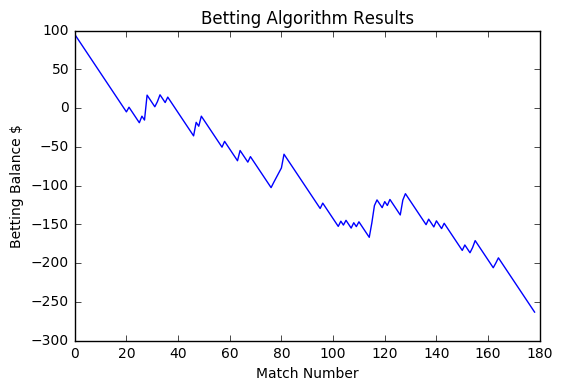

In [93]:
plt.plot(purse_track)
plt.xlabel('Match Number')
plt.ylabel('Betting Balance $')
plt.title('Betting Algorithm Results')

In [ ]:
Betting_df['purse'] = purse_track

In [ ]:
Betting_df